**Importing necessary libraries**

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/"

pages = 37
page_size = 100

reviews = []
dates = []

for i in range(1, pages+1):
  print(f"Scraping_page {i}")

  # Creating the url to loop through all the web pages
  url = f"{base_url}page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

  response = requests.get(url)
  print(f"Response_status {response.status_code}")

  content = response.content

  parsed_content = BeautifulSoup(content, 'html.parser')

  # collecting the review text
  for review in parsed_content.find_all("div",{"class": "text_content"}):
    reviews.append(review.get_text())

  # collecting the dates of the reviews
  for time in parsed_content.find_all("time",{"itemprop":"datePublished"}):
    dates.append(time.get_text())

  print(f"  ---> {len(reviews)} total reviews")
  print(f"  ---> {len(reviews)} total dates")


Scraping_page 1
Response_status 200
  ---> 100 total reviews
  ---> 100 total dates
Scraping_page 2
Response_status 200
  ---> 200 total reviews
  ---> 200 total dates
Scraping_page 3
Response_status 200
  ---> 300 total reviews
  ---> 300 total dates
Scraping_page 4
Response_status 200
  ---> 400 total reviews
  ---> 400 total dates
Scraping_page 5
Response_status 200
  ---> 500 total reviews
  ---> 500 total dates
Scraping_page 6
Response_status 200
  ---> 600 total reviews
  ---> 600 total dates
Scraping_page 7
Response_status 200
  ---> 700 total reviews
  ---> 700 total dates
Scraping_page 8
Response_status 200
  ---> 800 total reviews
  ---> 800 total dates
Scraping_page 9
Response_status 200
  ---> 900 total reviews
  ---> 900 total dates
Scraping_page 10
Response_status 200
  ---> 1000 total reviews
  ---> 1000 total dates
Scraping_page 11
Response_status 200
  ---> 1100 total reviews
  ---> 1100 total dates
Scraping_page 12
Response_status 200
  ---> 1200 total reviews
  ---> 

# **EDA**

In [47]:
data = pd.DataFrame()
data['Date'] = dates
data['Reviews'] = reviews

In [48]:
data.head()

,Date,Reviews
0,12th December 2023,✅ Trip Verified | Once again a terrible busine...
1,12th December 2023,✅ Trip Verified | BA A380's are showing their...
2,10th December 2023,✅ Trip Verified | Credit to BA - Flew to Sin...
3,10th December 2023,✅ Trip Verified | The check in area for prem...
4,9th December 2023,✅ Trip Verified | The flight took off a littl...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     3700 non-null   object
 1   Reviews  3700 non-null   object
dtypes: object(2)
memory usage: 57.9+ KB


**Missingness within the data**

In [7]:
data.isnull().sum()

Date       0
Reviews    0
dtype: int64

In [9]:
data['Reviews']

0       ✅ Trip Verified | Once again a terrible busine...
1       ✅ Trip Verified |  BA A380's are showing their...
2       ✅ Trip Verified |   Credit to BA - Flew to Sin...
3       ✅ Trip Verified |   The check in area for prem...
4       ✅ Trip Verified |  The flight took off a littl...
                              ...                        
3695    BA 059 London to Cape Town April 29 2014 econo...
3696    Las Vegas-LGW 777 3 class. Business. The uniqu...
3697    An interesting contrast on recent Gatwick to T...
3698    Heathrow Marrakech. Had previously travelled o...
3699    Business LHR to BKK. 747-400. First try back w...
Name: Reviews, Length: 3700, dtype: object

- It appears some of the reviews are Trip Verified and others aren't.
- Let's look into that.

In [33]:
present = 0
absent = 0
for i in data['Reviews']:
  if "|" in i:
    present += 1
  else:
    absent += 1

In [35]:
print(f"Tagged Reviews : {present}")
print(f"Untagged Reviews : {absent}")

Tagged Reviews : 2190
Untagged Reviews : 1510


- It appears we have some reviews missing the Trip Verified

# **NLTK**

**Text Preparation**

In [61]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [62]:
def split_by_pipe_and_extract_text(df, col):


  def split_by_pipe_and_extract_text_func(x):
    if "|" in x:
      return x.split("|")[1]
    else:
      return x

  return df[col].apply(split_by_pipe_and_extract_text_func)

In [63]:
def remove_re(text):

  # Create a regular expression to match punctuations and special characters.
  regex = re.compile(r"[^\w\s]")

  # Substitute all matches with an empty string.
  text = regex.sub("", text)

  return text

In [64]:
# a function to tokenize, lowercase, remove stopwords and lemmatize
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)


    return processed_text

In [65]:
data['cleaned_reviews'] = split_by_pipe_and_extract_text(data,"Reviews")
data['cleaned_reviews'] = data['cleaned_reviews'].apply(remove_re)
data['final_reviews'] = data['cleaned_reviews'].apply(preprocess_text)

In [66]:
data.head()

,Date,Reviews,cleaned_reviews,final_reviews
0,12th December 2023,✅ Trip Verified | Once again a terrible busine...,Once again a terrible business class experien...,terrible business class experience ba flight d...
1,12th December 2023,✅ Trip Verified | BA A380's are showing their...,BA A380s are showing their age hopefully the...,ba a380s showing age hopefully update interior...
2,10th December 2023,✅ Trip Verified | Credit to BA - Flew to Sin...,Credit to BA Flew to Singapore recently an...,credit ba flew singapore recently also back do...
3,10th December 2023,✅ Trip Verified | The check in area for prem...,The check in area for premium classes at Ga...,check area premium class gatwick nice queue ar...
4,9th December 2023,✅ Trip Verified | The flight took off a littl...,The flight took off a little late due to Hea...,flight took little late due heathrow congestio...


**VADER Model**

In [67]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [68]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
analyzer=SentimentIntensityAnalyzer()

In [69]:
analyzer.polarity_scores(data['final_reviews'][0])

{'neg': 0.233, 'neu': 0.739, 'pos': 0.028, 'compound': -0.9451}

In [70]:
def get_score(text):

    scores = analyzer.polarity_scores(text)

    return scores['compound']

In [71]:
def get_sentiment(compound):

  if compound >= 0.05:
      return 'Positive'
  elif compound < -0.05 :
      return 'Negative'
  else:
      return 'Neutral'


In [72]:
data['Sentiment'] = data['final_reviews'].apply(get_score)

In [73]:
data['label'] = data['Sentiment'].apply(get_sentiment)

In [75]:
data.head()

,Date,Reviews,cleaned_reviews,final_reviews,Sentiment,label
0,12th December 2023,✅ Trip Verified | Once again a terrible busine...,Once again a terrible business class experien...,terrible business class experience ba flight d...,-0.9451,Negative
1,12th December 2023,✅ Trip Verified | BA A380's are showing their...,BA A380s are showing their age hopefully the...,ba a380s showing age hopefully update interior...,0.9100,Positive
2,10th December 2023,✅ Trip Verified | Credit to BA - Flew to Sin...,Credit to BA Flew to Singapore recently an...,credit ba flew singapore recently also back do...,0.9761,Positive
3,10th December 2023,✅ Trip Verified | The check in area for prem...,The check in area for premium classes at Ga...,check area premium class gatwick nice queue ar...,0.9942,Positive
4,9th December 2023,✅ Trip Verified | The flight took off a littl...,The flight took off a little late due to Hea...,flight took little late due heathrow congestio...,0.8934,Positive


In [74]:
data['label'].value_counts()

Positive    2414
Negative    1216
Neutral       70
Name: label, dtype: int64

**Visualization**

<Axes: ylabel='label'>

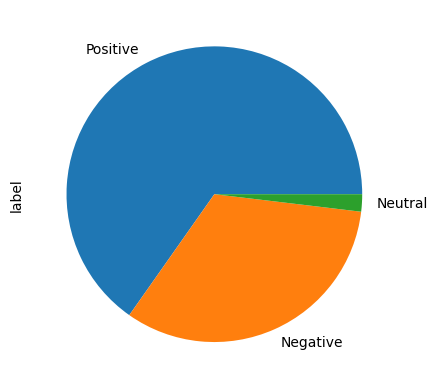

In [76]:
data['label'].value_counts().plot(kind='pie')

**Visualization over time**

In [77]:
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt


In [78]:
data['Date'] = pd.to_datetime(data['Date'])

In [79]:
data['Year'] = data['Date'].dt.year

In [81]:
viz_df = data.groupby('Year',as_index=False)['label'].value_counts()

In [82]:
viz_df.head()

,Year,label,count
0,2012,Positive,2
1,2014,Positive,356
2,2014,Negative,103
3,2014,Neutral,9
4,2015,Positive,524


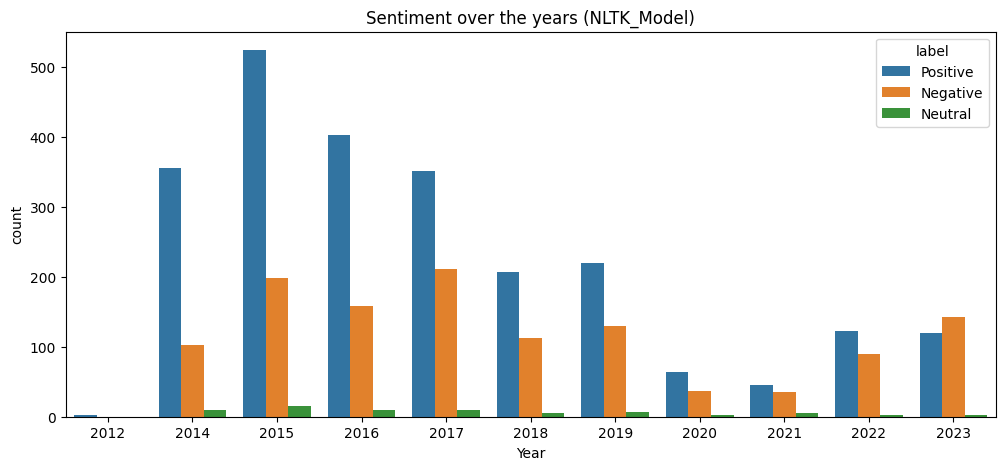

In [83]:
plt.figure(figsize=(12,5))
sns.barplot(data=viz_df,x='Year',y='count',hue='label')
plt.title('Sentiment over the years (NLTK_Model)')
plt.show()

**Wordclouds**

In [94]:
from wordcloud import WordCloud

In [86]:
pos_df = data[data['label'] == 'Positive']
neg_df = data[data['label'] == 'Negative']

In [102]:
# Positive

pos_text = " ".join(pos_df.Reviews.tolist())
pos_word_cloud = WordCloud( background_color = 'white').generate(pos_text)

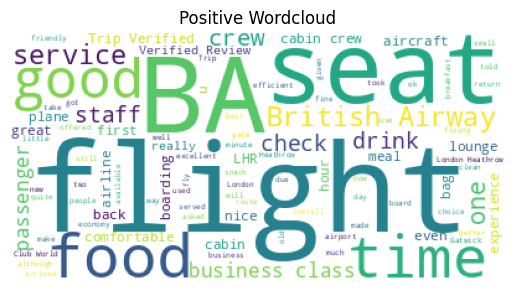

In [106]:
plt.imshow(pos_word_cloud)
plt.axis("off")
plt.title('Positive Wordcloud')
plt.show()

In [104]:
# Negative

neg_text = " ".join(neg_df.Reviews.tolist())
neg_word_cloud = WordCloud(background_color='white').generate(neg_text)

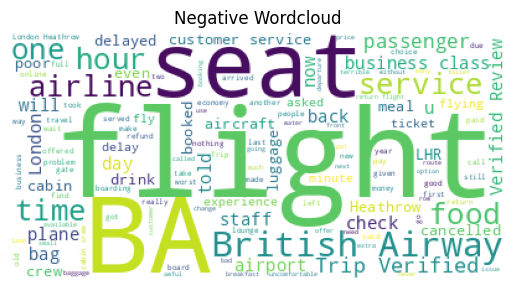

In [105]:
plt.imshow(neg_word_cloud)
plt.axis("off")
plt.title("Negative Wordcloud")
plt.show()